In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import requests
import re

In [2]:
data = pd.read_csv("cog_bias.csv", header=0)

In [3]:
data.describe()

,What day of the month is your birthday (1-31)?,"Without looking it up, what's your best guess of how much they sold the rights for, in millions of dollars? Please write the number that represents your best guess; for example, if you think it is $15 million, type in 15.","How many occurrences of the letter ""F"" are there in this sentence: ""FINISHED FILES ARE THE RESULT OF YEARS OF SCIENTIFIC STUDY COMBINED WITH THE EXPERIENCE OF YEARS.""",A bat and a ball cost $110 in total. The bat costs $100 more than the ball. How much does the ball cost?,"A lot of people are going to answer this survey. For this question, they (and you) will all choose a number between 0 and 100. What do you think will be half the average of everybody's answer to this question? Please respond with a number between 0 and 100.","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to investigate things.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I generate few novel ideas.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I make many novel contributions.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I seldom notice what other people are up to.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I avoid thought provoking conversations.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am very creative.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am very curious.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I try to think of new ways of doing things.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am rarely aware of changes.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to be challenged intellectually.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I find it easy to create new and effective ideas.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am rarely alert to new developments.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to figure out how things work.]","Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am not an original thinker.]"
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,108.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,17.247706,13.633028,4.788991,7.679633,27.293578,5.504587,3.574074,4.275229,2.853211,2.293578,4.495413,5.431193,5.348624,2.311927,5.550459,4.587156,2.541284,5.394495,2.889908
std,9.017633,14.545370,1.534018,10.270733,18.694945,1.456936,1.919909,1.626582,1.626321,1.523293,1.636527,1.529748,1.511537,1.274372,1.443287,1.717077,1.384652,1.509343,1.657416
min,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,10.000000,4.000000,3.000000,5.000000,15.000000,5.000000,2.000000,3.000000,2.000000,1.000000,4.000000,4.000000,5.000000,1.000000,5.000000,3.000000,2.000000,5.000000,2.000000
50%,17.000000,10.000000,5.000000,5.000000,25.000000,6.000000,3.000000,5.000000,2.000000,2.000000,5.000000,6.000000,6.000000,2.000000,6.000000,5.000000,2.000000,6.000000,2.000000
75%,25.000000,20.000000,6.000000,10.000000,32.000000,7.000000,5.000000,5.000000,4.000000,3.000000,6.000000,7.000000,6.000000,3.000000,7.000000,6.000000,3.000000,7.000000,4.000000
max,31.000000,100.000000,8.000000,90.000000,100.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


**Raw Data Processing**

---

**Rationality Scales**

Since the column names are complete sentences, I transformed them into simplier forms for better understanding. Additionally, the answers attained from the questionnaire are non-numeric. I quantified them as indicators of rationality.

The rule of quantification: correct choice= 2 points, incorrect answer = 0 point.

**Personality Traits**

For the personality traits, there are already numeric self-evaluation data, which is easy for data processing. Therefore, I only renamed the columns for simplification.

In [5]:
# Adjusted transformation functions with the correct column names and conditions
def transform_differentiating(answer, condition):
    mapping = {
        "Yes, I see the missing fruit": 2,
        "No, I don't see the missing fruit": 0,
        "No, I don't think there is a missing fruit": 0
    }
    return mapping.get(answer,0)  # Return None for unexpected answers

def transform_illusion_debiasing(answer, condition):
    if condition in ["Mindequal", "Mindless"]:  # Assuming these correspond to "Low Mindful"
        mapping_low_mindful = {
            "I see a vase": 0,
            "I see two faces": 0,
            "I see both a vase and the two faces": 2
        }
        return mapping_low_mindful.get(answer, None)
    elif condition == "Mindful":
        mapping_mindful = {
            "I see the vase and faces on the left and the vase and faces on the right.": 2,
            "I see only the vase on the left, and the vase and faces on the right.": 1,
            "I see both a vase and the two faces": 2,
            "I see a vase": 0
        }
        return mapping_mindful.get(answer, None)
    return None  # Handle cases where condition is not specified or is unexpected

# Applying transformations to the dataset
data['differentiating'] = data.apply(lambda row: transform_differentiating(row['Can you spot the missing fruit?'], row['Condition']), axis=1)
data['illusion_debiasing'] = data.apply(lambda row: transform_differentiating(row['What can you see here?'], row['Condition']), axis=1)

def transform_loss_aversion(answer):
    mapping = {
        "You get $20 for sure.": 0,
        "You toss a fair coin. Heads you get $300. Tails you lose $100.": 1
    }
    return mapping.get(answer, None)

def transform_hyperbolic_discounting(answer):
    mapping = {
        "$1,500 today": 0,
        "$1,800 one month from now": 1
    }
    return mapping.get(answer, None)

# Applying transformations to the dataset
data['loss_aversion'] = data['Suppose you had to choose one of these two options. Which would you prefer?'].apply(transform_loss_aversion)
data['hyperbolic_discounting'] = data['Would you prefer to receive $1,500 today or $1,800 one month from now?'].apply(transform_hyperbolic_discounting)

def transform_conjunction_fallacy(answer):
    mapping = {
        "Linda is a bank teller.": 2,
        "Linda is a bank teller and is active in the feminist movement.": 0
    }
    return mapping.get(answer, None)

def transform_gambling_fallacy(answer):
    mapping = {
        "More likely to come up tails": 0,
        "Equally likely to come up heads or tails": 2,
        "More likely to come up heads": 0
    }
    return mapping.get(answer, None)

def transform_confirmation_bias(answer):
    mapping = {
        "Turn over cards 3 and 4 only.": 2
    }
    return mapping.get(answer, 0) if answer is not None else None

def transform_positional_bias(answer):
    mapping = {
        "A job paying $44,000 in a firm where the average salary is $50,000": 2,
        "A job paying $42,000 in a firm where the average salary is $38,000": 0
    }
    return mapping.get(answer, None)

def transform_emotional_attachment(answer):
    mapping = {
        "Yes, I would sell it": 2,
        "No, I would not sell it": 0
    }
    return mapping.get(answer, None)

def transform_fairness(answer):
    mapping = {
        "Completely fair": 2,
        "Acceptable": 1,
        "Unfair": 0,
        "Very unfair": 0
    }
    return mapping.get(answer, None)

def transform_availability_bias(answer):
    mapping = {
        "R is more likely to appear as the first letter in a word": 0,
        "R is more likely to appear as the third letter in a word": 2
    }
    return mapping.get(answer, None)

def transform_equiprobability_illusion(answer):
    mapping = {
        "Al": 0,
        "Bob": 2,
        "Carl": 0
    }
    return mapping.get(answer, None)

def transform_representative_bias(answer):
    mapping = {
        "Librarian": 0,
        "Farmer": 2
    }
    return mapping.get(answer, None)

def transform_endowment_effect(answer):
    mapping = {
        "Yes": 2,
        "No": 0
    }
    return mapping.get(answer, None)

def transform_leaping_to_conclusions(answer):
    mapping = {
        "A": 0,
        "B": 0,
        "C": 2,
        "D": 0,
        "E": 0
    }
    return mapping.get(answer, None)

def transform_cognitive_reflection(answer):
    mapping = {
        "5": 2
    }
    return mapping.get(answer, 0) if answer is not None else None

def transform_disposition_effect(answer):
    mapping = {
        "Hold on no matter what until the price gets back to $50 or higher, then sell": 0,
        "Sell now": 2,
        "Sell if it drops even lower to $15, or if it gets back up to $50": 0
    }
    return mapping.get(answer, None)

# Applying transformations to the dataset
data['conjunction_fallacy'] = data['Linda is 31 years old, single, outspoken, and very bright. She majored in philosophy. As a student, she was deeply concerned with issues of discrimination and social justice, and also participated in anti-nuclear demonstrations. Which is more probable?'].apply(transform_conjunction_fallacy)
data['gambling_fallacy'] = data['If you take a coin that you happen to have out of your pocket, and you toss it high in the air in five times, and it surprisingly comes up heads all five times, what do you think will happen if you toss it one more time?'].apply(transform_gambling_fallacy)
data['confirmation_bias'] = data['Below are four cards. You would like to evaluate whether the following rule is true: "Any card that has a vowel on one side will have an even number on the other side." Turn over only those cards that you need to, in order to check the rule.'].apply(transform_confirmation_bias)
data['positional_bias'] = data['Which of these two job offers would you prefer? Assume there are basically no other differences between the two opportunities.'].apply(transform_positional_bias)
data['emotional_attachment'] = data['A few days ago, you bought a ticket to a sold-out concert. You really love their music and would have paid up to $500 for the ticket, but you got a great deal and were able to buy it for only $200. Today, you notice that richer or more desperate fans on the internet would pay up to $3,000 for your ticket. Would you sell it?'].apply(transform_emotional_attachment)
data['fairness'] = data['Your local hardware store has been selling snow shovels for $15. This morning, after a very large snowstorm, the store raises the price to $20. How would you rate this action by the store?'].apply(transform_fairness)
data['availability_bias'] = data['Consider the letter R. Is R more likely to appear as the first letter in a word, or as the third letter?'].apply(transform_availability_bias)
data['equiprobability_illusion'] = data['You see three people named Al, Bob, and Carl wanting to play chess at a public park. You know that two of them are equally ranked amateurs, and one is a pro who will always beat either amateur, but you don\'t know which one is the pro. They ask you to match them up in a tournament. You randomly guess that Al is the pro so you have Bob and Carl face off first. Bob wins that game, and now will face Al for the championship. If you had to bet, who do you now think is the pro?'].apply(transform_equiprobability_illusion)
data['representative_bias'] = data['An individual has been described by a neighbor as follows: “Steve is very shy and withdrawn, invariably helpful but with very little interest in people or in the world of reality. A meek and tidy soul, he has a need for order and structure, and a passion for detail.” Is Steve more likely to be a librarian or a farmer?'].apply(transform_representative_bias)
data['endowment_effect'] = data['You just paid $1 for a lottery ticket with random numbers, and you haven\'t seen the numbers yet, when suddenly someone offers to pay you $2 for your lottery ticket. (They haven\'t seen your random numbers yet either.) There is still plenty of time for you to buy more lottery tickets before the drawing. Would you sell your ticket for $2?'].apply(transform_endowment_effect)
data['leaping_to_conclusions'] = data['Which of these does not belong? (There is only one correct answer.)'].apply(transform_leaping_to_conclusions)
data['cognitive_reflection'] = data['A bat and a ball cost $110 in total. The bat costs $100 more than the ball. How much does the ball cost?'].apply(transform_cognitive_reflection)
data['disposition_effect'] = data['You bought one hundred shares of a stock when it cost $50. It now costs $30. You no longer like the stock: if you weren\'t already an owner of the stock, you would not want to buy it now. What do you want to do with the shares that you do currently own?'].apply(transform_disposition_effect)


In [6]:
# Display the transformed data to check
data[['differentiating', 'illusion_debiasing', 'loss_aversion', 'hyperbolic_discounting', 'conjunction_fallacy','gambling_fallacy','confirmation_bias','positional_bias','emotional_attachment','fairness','availability_bias','equiprobability_illusion','representative_bias','endowment_effect','leaping_to_conclusions','disposition_effect']].head()

,differentiating,illusion_debiasing,loss_aversion,hyperbolic_discounting,conjunction_fallacy,gambling_fallacy,confirmation_bias,positional_bias,emotional_attachment,fairness,availability_bias,equiprobability_illusion,representative_bias,endowment_effect,leaping_to_conclusions,disposition_effect
0,0,0,0,0,0,0,0,2,2,1,2,0,0,0,0.0,0
1,2,0,1,1,2,2,2,2,0,2,0,2,0,2,0.0,2
2,2,0,1,1,2,2,0,2,2,1,2,2,2,2,0.0,2
3,2,0,1,1,2,2,0,0,0,1,2,0,0,0,NaN,0
4,2,0,0,1,0,0,0,2,0,1,0,0,2,2,0.0,0


In [7]:
# Renaming the columns for personality traits
data.rename(columns={
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I generate few novel ideas.]': 'Less_creative',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I make many novel contributions.]': 'Novelty_producing',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I seldom notice what other people are up to.]': 'Engagement',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I avoid thought provoking conversations.]': 'Low_novelty_seeking',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am very creative.]': 'Creativity',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am very curious.]': 'Curiosity',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I try to think of new ways of doing things.]': 'Novelty_methods',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am rarely aware of changes.]': 'Agility',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to be challenged intellectually.]': 'Intellectual_challenge',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I find it easy to create new and effective ideas.]': 'Creative_producing',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am rarely alert to new developments.]': 'Insight_of_environment',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to figure out how things work.]': 'Aspiration_to_knowledge',
    'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I am not an original thinker.]': 'Conservative_thinking'
}, inplace=True)


**I. Building Models for Rationality and Personality**

---

**Methodology:** Decision Tree

In [10]:
numeric_columns

Index(['What day of the month is your birthday (1-31)?',
       'Without looking it up, what's your best guess of how much they sold the rights for, in millions of dollars? Please write the number that represents your best guess; for example, if you think it is $15 million, type in 15.',
       'How many occurrences of the letter "F" are there in this sentence: "FINISHED FILES ARE THE RESULT OF YEARS OF SCIENTIFIC STUDY COMBINED WITH THE EXPERIENCE OF YEARS."',
       'A bat and a ball cost $110 in total. The bat costs $100 more than the ball. How much does the ball cost?',
       'A lot of people are going to answer this survey. For this question, they (and you) will all choose a number between 0 and 100. What do you think will be half the average of everybody's answer to this question? Please respond with a number between 0 and 100.',
       'Rate each phrase about you, from 1 = strongly disagree to 7 = strongly agree. [I like to investigate things.]',
       'Less_creative', 'Novelt

In [16]:
# Replace NaNs with 0
data_filled = data.fillna(0)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

numeric_columns = data_filled.select_dtypes(include=['number']).columns

rationality_columns = ['differentiating', 'illusion_debiasing', 'loss_aversion', 'hyperbolic_discounting',
                      'conjunction_fallacy', 'gambling_fallacy', 'confirmation_bias', 'positional_bias',
                      'emotional_attachment', 'fairness', 'availability_bias', 'equiprobability_illusion',
                      'representative_bias', 'endowment_effect', 'leaping_to_conclusions', 'disposition_effect']

personality_columns = ['Less_creative', 'Novelty_producing', 'Engagement', 'Low_novelty_seeking',
          'Creativity', 'Curiosity', 'Novelty_methods', 'Agility', 'Intellectual_challenge',
          'Creative_producing', 'Insight_of_environment', 'Aspiration_to_knowledge', 'Conservative_thinking']
# Extract only the rationality columns from the DataFrame
X = data_filled[personality_columns]

y = data_filled[rationality_columns]
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

import numpy as np

# Calculate accuracy for each label separately
accuracies = []
for i in range(y_test.shape[1]):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred[:, i])
    accuracies.append(accuracy)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 0.5625


**II. Finding Correlation between Rationality and Personality Traits**

In [17]:
# Calculate the total rationality score
data_filled['total_rationality_score'] = data_filled[rationality_columns].sum(axis=1)

# You can also drop the individual rationality columns if you no longer need them
data_filled.drop(columns=rationality_columns, inplace=True)


In [18]:
# II. Under the mindful condition, find the correlation between rationality and personality

# Calculate the correlation between total rationality score and personality traits
correlation = data_filled[['total_rationality_score'] + personality_columns].corr()

# Print correlation matrix
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
                         total_rationality_score  Less_creative  \
total_rationality_score                 1.000000      -0.099381   
Less_creative                          -0.099381       1.000000   
Novelty_producing                       0.130794       0.063807   
Engagement                             -0.020692       0.125106   
Low_novelty_seeking                    -0.188294       0.111708   
Creativity                              0.082771       0.110075   
Curiosity                               0.179957       0.263633   
Novelty_methods                         0.064690       0.250628   
Agility                                 0.071311      -0.020223   
Intellectual_challenge                  0.133093       0.262782   
Creative_producing                      0.067847       0.109320   
Insight_of_environment                  0.000160       0.082887   
Aspiration_to_knowledge                 0.104495       0.270879   
Conservative_thinking                  -0.

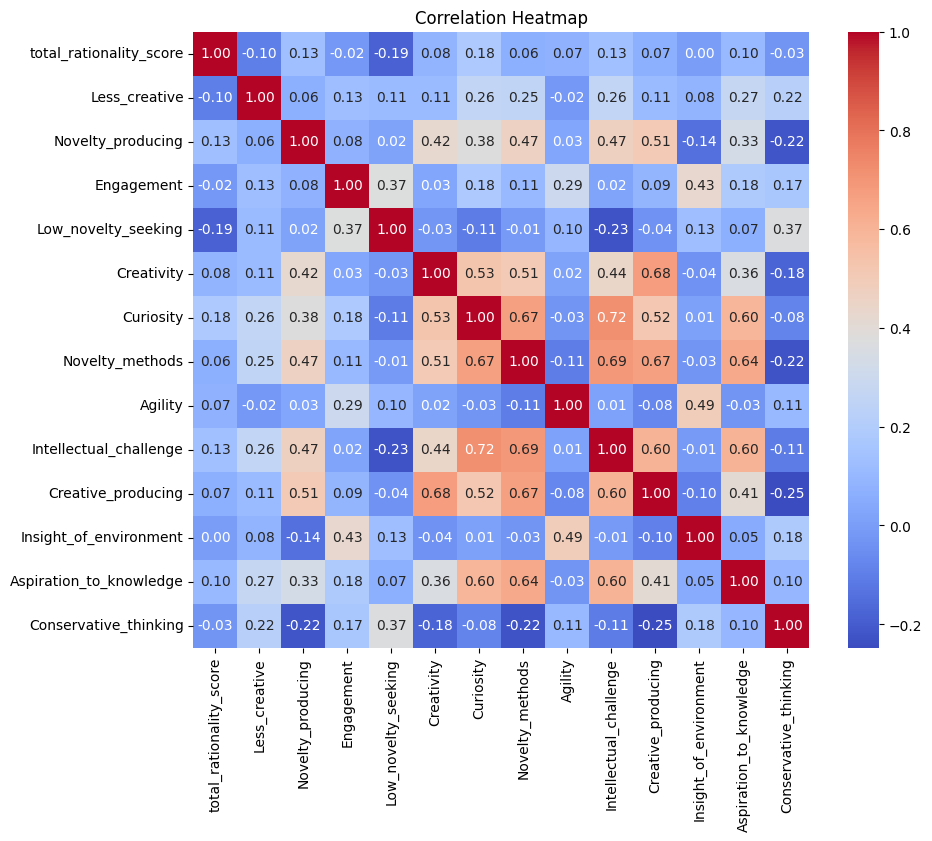

In [19]:
#Visualization of correlation
import seaborn as sns
import matplotlib.pyplot as plt

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Heatmap')
plt.show()